<a href="https://colab.research.google.com/github/vitorfrois/GooGooBot/blob/main/BotTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import numpy as np
import time 
import copy

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)                       
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


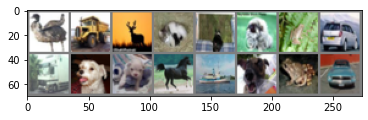

bird  truck deer  cat   cat   dog   frog  car   truck dog   dog   horse ship  dog   frog  car  


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print(labels)
# print((images[0]-0.5)*2)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

do = nn.Dropout(0.25)

net = torchvision.models.resnet18(weights='DEFAULT')
# for param in net.parameters():
#     param.requires_grad = False
num_ftrs = net.fc.in_features
net.fc = nn.Sequential(
     nn.Dropout(0.5),
     nn.Linear(num_ftrs, 10)
)

net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
PATH = './cifar_net.pth'

In [ ]:
def train_loop(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    model.train() 

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    
    for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}\n-------------------------------")
      total = 0
      running_loss = 0.0
      correct = 0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          #compute acc
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          #compute loss
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()

          n = 500
          if i % n == n-1:    # print every 2000 mini-batches
            print(f'[{i + 1:5d}] loss: {running_loss / n:.3f}')
            running_loss = 0.0

          
      acc = correct / total
      print(f'Train accuracy: {100 * acc:.3f} %')
      scheduler.step() #will not use scheduler intended to overfit
      epoch_acc = test_loop(net)
      print(f'Current Learning Rate: {scheduler.get_last_lr()[0]:.7f}')
      if epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), PATH)
          best_model_weights = model.state_dict()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')


    # load best model weights
    return best_model_weights

def test_loop(model):
  net.eval()
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = net(inputs)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  acc = correct / total
  print(f'Test accuracy: {100 * acc:.3f} %')
  return acc


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.93)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #83% + lr = 0.001

In [ ]:
epochs = 1
best_weights = train_loop(net, criterion, optimizer, scheduler, epochs)
  
print("Done!")

Epoch 1
-------------------------------
[  500] loss: 1.747
[ 1000] loss: 1.344


KeyboardInterrupt: ignored

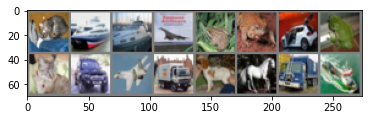

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

In [ ]:
# PATH2 = './cifar_net2.pth'
# torch.save(best_weights, PATH)
# net = net.to(device)
net.load_state_dict(torch.load(PATH))

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        # print(outputs)
        _, predictions = torch.max(outputs, 1)
        # print(predictions)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.7 %
Accuracy for class: car   is 70.7 %
Accuracy for class: bird  is 65.6 %
Accuracy for class: cat   is 21.0 %
Accuracy for class: deer  is 56.1 %
Accuracy for class: dog   is 59.4 %
Accuracy for class: frog  is 68.1 %
Accuracy for class: horse is 67.1 %
Accuracy for class: ship  is 67.3 %
Accuracy for class: truck is 73.7 %


In [ ]:
print(data[0].size())

torch.Size([16, 3, 32, 32])
